## Importing Packages Needed

In [1]:
import numpy as np
import matplotlib.pyplot as py
from scipy.optimize import curve_fit
import collections as col
import statistics
from scipy.interpolate import UnivariateSpline

## Definition of Named Tuples

In [2]:
component = col.namedtuple('component','phase intensity')
ind_component = col.namedtuple('component','phase intensity width')
pulse_component = col.namedtuple('pulse_component','frequency comp1 comp2 errors')
component_separation = col.namedtuple('component_separation','frequency separation')

# Definition of Functions

Gaussian Fitting Functions:

In [3]:
def gauss(x,amp,cen,sd):
    return amp*np.exp(-(x-cen)**2/(2*sd**2))\

def multi_gauss(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        y = y +  a * np.exp( -(((x-b)**2) / (2*c**2)) )
    return y

In [4]:
"""
    Used to get the parameters, covariance matrix and errors for any number of gaussian fits, through and expected value. 
"""
def fitting_parameters(x,y,expected,bound):
    """
    bound=([],[])
    for i in range(len(expected)):
        bound[0].append(0)
        bound[1].append(np.inf)
    """
        
    params,cov=curve_fit(multi_gauss,x,y,expected, bounds=bound)
    sigma=np.sqrt(np.diag(cov))
    return params, cov, sigma

Chi Squared functions

In [5]:
"""
    Compute the data's chi squared values.

    Parameters:
    -----------
    observed_values: list
        A list of floats - the raw data
    expected_values: list
        A list of floats - the expected data or the fit
    err: float/list
        The error across all data - standard deviation of the noise

    Returns:
    --------
    test_statistic: float
        The chi squared value of the data
    
    Created by Keegan Smith
"""
def chsq(observed_values, expected_values, err):
    test_statistic=0
    for observed, expected in zip(observed_values, expected_values):
        test_statistic+=((float(observed)-float(expected))/float(err))**2
    return test_statistic

def chsq_err(observed_values, expected_values, err):
    #Same as above but used when there is a different error for each point
    test_statistic=0
    for observed, expected, error in zip(observed_values, expected_values, err):
        test_statistic+=((float(observed)-float(expected))/float(error))**2
    return test_statistic

Error Finding Functions

In [6]:
def sigmaClip(data, alpha=3, tol=0.1, ntrials=10):
    """
    Compute the data's median, m, and its standard deviation, sigma.
    Keep only the data that falls in the range (m-alpha*sigma,m+alpha*sigma) for some value of alpha, and discard everything else.
    This operation is repeated ntrials number of times or until the tolerance level is hit.

    Parameters:
    -----------
    data: list
        A list of floats - the data to clip
    alpha: float
        OPTIONAL - Determines the number of sigmas to use to determine the upper nad lower limits. Default=3
    tol: float
        OPTIONAL - The fractional change in the standard deviation that determines when the tolerance is hit. Default=0.1
    ntrils: int
        OPTIONAL - The maximum number of times to apply the operation. Default=10

    Returns:
    --------
    oldstd: float
        The std of the clipped data
    x: list
        The data list that contains only noise, with nans in place of 'real' data
    
    Created by Nick Swainston
    """
    x = np.copy(data)
    oldstd = np.nanstd(x)
    #When the x[x<lolim] and x[x>hilim] commands encounter a nan it produces a
    #warning. This is expected because it is ignoring flagged data from a
    #previous trial so the warning is supressed.
    old_settings = np.seterr(all='ignore')
    for trial in range(ntrials):
        median = np.nanmedian(x)

        lolim = median - alpha * oldstd
        hilim = median + alpha * oldstd
        x[x<lolim] = np.nan
        x[x>hilim] = np.nan

        newstd = np.nanstd(x)
        tollvl = (oldstd - newstd) / newstd

        if tollvl <= tol:
            np.seterr(**old_settings)
            return oldstd, x

        if trial + 1 == ntrials:
            np.seterr(**old_settings)
            return oldstd, x

        oldstd = newstd

In [7]:
def multi_gauss_ddx(x, *params):
    #derivative of gaussian
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        y = y - a/c**2 * (x - b) * np.exp( -(((x-b)**2) / (2*c**2)) )
    return y

def multi_gauss_d2dx2(x, *params):
    #double derivative of gaussian
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        y = y + (multi_gauss(x, a, b, c) / c**2) * (((x - b)**2)/(c**2) - 1)
    return y

def jacobian_slope(x, *params):
    """
    Evaluates the Jacobian matrix of a gaussian slope at a single point, x

    Parameters:
    -----------
    x: float
        The point to evaluate
    *params: list
        A list containing three parameters per gaussian component in the order: Amp, Mean, Width

    Returns:
    --------
    J: numpy.matrix
        The Jacobian matrix
    """
    def dda(a, b, c, x):
        return -multi_gauss(x, a, b, c) * (x - b)/(c**2)/a
    def ddb(a, b, c, x):
        return multi_gauss(x, a, b, c) * (1 - (x - b)**2/(c**2))/c**2
    def ddc(a, b, c, x):
        return multi_gauss(x, a, b, c) * (x - b)/(c**3) * (2 - (x-b)**2/(c**2))
    J = []
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        mypars = [a, b, c, x]
        J.append(dda(*mypars))
        J.append(ddb(*mypars))
        J.append(ddc(*mypars))
    J = np.asmatrix(J)
    return J

In [8]:
def find_x_err(x, popt, pcov):
    """
    Finds the error in the horizontal position of a gaussian fit at the point x.
    Uses the equation sigma_x = sigma_y/d2ydx2 where:
    sigma_x = error in x
    d2ydx2 = second derivative of the gaussian function at point x
    sigma_y = sqrt.J*C*J_T
    J = Jacobian evalutated at point x
    C = covariance matrix of gaussian fit
    J_T = transposed jacobian

    Parameters:
    -----------
    x: list
        A list of points to evaluate the error at
    popt: list
        The parameters used to describe the gaussian fit
    pcov: numpy.matrix
        The covariance matrix corresponding to popt

    Returns:
    --------
    x_err: list
        The error evaluated at each point, x
    """
    x_err = []
    for i, point in enumerate(x):
        J = jacobian_slope(point, *popt)
        d2dx2 = multi_gauss_d2dx2(point, *popt)
        JC = np.matmul(J, pcov)
        sigma_y = np.sqrt( np.matmul(JC, np.transpose(J)).item(0) )
        x_err.append(sigma_y / abs(d2dx2))
    return x_err

Finding Peak of Fittings Function

In [9]:
def find_minima_maxima_gauss(popt, pcov, x_length):
    """
    Finds all peaks of a gaussian function, where the derivative is equal to zero. 

    Parameters:
    -----------
    popt: list
        A list of length 3N where N is the number of gaussians. This list contains the parameters amp, mean, centre respectively
    x_length: int
        The length of the list used to fit the gaussian

    Returns:
    --------
    minima: list
        A list of the minimum points of the fit
    maxima: list
        A list of the maximum points of the fit
    """
    #Create the derivative list and spline it to find roots
    x = np.linspace(0, x_length-1, x_length)
    dy = multi_gauss_ddx(x, *popt)
    spline_dy = UnivariateSpline(x, dy, s=0)
    roots = spline_dy.roots()
    
    #Find which are max and min
    maxima = []
    minima = []
    for root in roots:
        idx = int(root + 0.5)
        if dy[idx-1] > dy[idx]:
            maxima.append(root)
        else:
            minima.append(root)            
            
    minima_e = find_x_err(minima, popt, pcov)
    maxima_e = find_x_err(maxima, popt, pcov)
    
    return minima, maxima, minima_e, maxima_e

In [10]:
def gauss_peaks(fit, nofreqband, freqband, pcov, params, freq_low, freq_high, noise, data = 'parkes', freq=0):
    """
    Find the peaks of a gaussian fit, take the highest two and create a profile_comp.
    Also converts the phase into degrees and the frequency into MHz.
    
    Parameters:
    -----------
    fit: list
        the gaussian fit to find peaks of
    nofreqband: int
        total number of frequency bins 
    freqband: int
        current frequency band which has been fit
    pcov: list
        the covariance matrix from the fit
    params: list
        the parameters for the fit
    freq_low: int
        the lower boundary of the frequency range
    freq_high: int
        the high boundary of the frequency range
    Returns:
    --------
    profile_comp: pulse_component
        carrys information about each component at a certain frequency
    """
    
    deg_mod=360/len(fit)
    
    #Find the peaks of the fit, and the intensity at those peaks
    minima, peakpos, minima_e, err = find_minima_maxima_gauss(params, pcov, len(fit))
    peakint = multi_gauss(peakpos, *params)
    
    """
    #Removes peaks until only two highest remain - which also have to be the two outer peaks
    #If the highest do not correspond to the outer, the frequency band is not used
    while len(peakpos)>2:
        mn=min(peakint)
        peakint = list(peakint)
        rm = peakint.index(mn)
        if rm!=0 and rm!=len(peakpos)-1:
            del peakpos[rm]
            del peakint[rm]
            del err[rm]
        else:
            break 
    """

    #Assign the peaks to the correct component label, also converts phase from bins to degrees
    
    component1=0
    component2=0
    errr=[]
    
    if(max(peakint)/noise)>3:
        if data=='parkes':
            for n,p in enumerate(peakpos):
                if p>670 and p<710:
                    component1 = component(phase=(deg_mod)*peakpos[n], intensity=peakint[n])
                    errr.append(err[n])
                elif p>720:
                    component2 = component(phase=(deg_mod)*peakpos[n], intensity=peakint[n])
                    errr.append(err[n])
        elif data!='parkes' and len(peakpos)==2:
            component1 = component(phase=(deg_mod)*peakpos[0], intensity=peakint[0])
            errr.append(err[0])
            component2 = component(phase=(deg_mod)*peakpos[1], intensity=peakint[1])
            errr.append(err[1])
    else:
        print("Too noisey", freqband)
                
    if component1==0 or component2==0:
        component1 = component(phase=0, intensity=0)
        component2 = component(phase=0, intensity=0)
        error = 0   
        print("peaks",len(peakpos),peakpos,"band", freqband)
    else:
        error = np.array(errr)*(deg_mod)
        
    """
    if len(peakpos)==2 and (max(peakint)/noise)>3:
        component1 = component(phase=(deg_mod)*peakpos[0], intensity=peakint[0])
        component2 = component(phase=(deg_mod)*peakpos[1], intensity=peakint[1])
        error = np.array(err)*(deg_mod)
    elif len(peakpos)==3 and (max(peakint)/noise)>3:
        component1 = component(phase=(deg_mod)*peakpos[1], intensity=peakint[1])
        component2 = component(phase=(deg_mod)*peakpos[2], intensity=peakint[2])
        error = np.array(err)*(deg_mod)        
    elif len(peakpos)==4 and (max(peakint)/noise)>3:
        component1 = component(phase=(deg_mod)*peakpos[1], intensity=peakint[1])
        component2 = component(phase=(deg_mod)*peakpos[3], intensity=peakint[3])
        error = np.array(err)*(deg_mod)   
    else:
        component1 = component(phase=0, intensity=0)
        component2 = component(phase=0, intensity=0)
        error = 0       
   """
   
    #Converts the frequency from bins to MHz    
    if data=='parkes':
        freq=(((freq_high-freq_low)/nofreqband)*(freqband))+freq_low+((freq_high-freq_low)/(nofreqband*2))
    else:
        freq=freq[freqband]

    profile_comp = pulse_component(frequency=freq, comp1=component1, comp2=component2, errors=error)

    return profile_comp

In [11]:
def fit_peaks(fit, freqband, pcov, params, noise, frequency):
    
    deg_mod=360/len(fit)
    
    #Find the peaks of the fit, and the intensity at those peaks
    peakpos = params[1]
    paramint = params[0]
    errcov = np.sqrt(np.diag(pcov))
    err = errcov[1]
    if len(params)>3:
        peakpos=np.append(peakpos,params[4])
        paramint=np.append(paramint,params[3])
        err = np.append(err,errcov[4])
    if len(params)>6:
        peakpos=np.append(peakpos,params[7])
        paramint=np.append(paramint,params[6])
        err=np.append(err,errcov[7])

    print(peakpos)
    peakint = multi_gauss(peakpos, *params)
    print(peakint)

    #Removes peaks until only two highest remain - which also have to be the two outer peaks
    #If the highest do not correspond to the outer, the frequency band is not used
    while len(peakpos)>2:
        mn=min(paramint)
        paramint = list(paramint)
        rm = paramint.index(mn)   
        print(rm)
        peakpos=np.delete(peakpos,rm)
        peakint=np.delete(peakint,rm)
        err=np.delete(err,rm)

    #Assign the peaks to the correct component label, also converts phase from bins to degrees
    
    component1=0
    component2=0
    errr=[]
    
    if(max(peakint)/noise)>3:
        if len(peakpos)==2:
            component1 = component(phase=(deg_mod)*peakpos[0], intensity=peakint[0])
            errr.append(err[0])
            component2 = component(phase=(deg_mod)*peakpos[1], intensity=peakint[1])
            errr.append(err[1])
    else:
        print("Too noisey", freqband)
                
    if component1==0 or component2==0:
        component1 = component(phase=0, intensity=0)
        component2 = component(phase=0, intensity=0)
        error = 0   
        print("peaks",len(peakpos),peakpos,"band", freqband)
    else:
        error = np.array(errr)*(deg_mod)

    #Converts the frequency from bins to MHz    
    freq=frequency[freqband]
    
    profile_comp = pulse_component(frequency=freq, comp1=component1, comp2=component2, errors=error)

    return profile_comp

In [12]:
"""
    Graphing Sub-pulse operation:
    Used to get the correct x, y and error arrays created for graphing the data and finding a fit.
"""
def graphing_comp(fit_comp,comp_num):
        phase_comp=[]
        frequency_comp=[]
        comp_err=[]

        for i in range(0,len(fit_comp)):
            if fit_comp[i][comp_num][0]!=0:
                phase_comp.append(fit_comp[i][comp_num][0])
                frequency_comp.append(fit_comp[i][0])
                comp_err.append(fit_comp[i][3][comp_num-1])

        return phase_comp, frequency_comp, comp_err    

Removing outliers

In [13]:
"""
    Used to remove outliers more than the threshold number of standard deviations from the mean. 
    Also removes points with high errors (greater than 100 degrees).
"""
def detect_outlier(frequency_comp, phase_comp, comp_err , threshold):
    phase=[]
    frequency=[]
    err=[]
    
    #Find mean and standard deviation of data
    mean_1 = np.mean(phase_comp)
    std_1 =np.std(phase_comp)
    
    for i in range(len(phase_comp)):
        #Find z score
        z_score= (phase_comp[i] - mean_1)/std_1 
        #Only include points which have a z score under the threshold value, and with errors less than 100 degrees
        if np.abs(z_score) < threshold and comp_err[i]<20:
            phase.append(phase_comp[i])
            frequency.append(frequency_comp[i])
            err.append(comp_err[i])
    return frequency, phase, err

Plotting Fittings Functions

In [14]:
"""
    Plotting functions to plot the gaussian fit, three gaussian fit with the gaussians filled in,
    and the peaks of the gaussian fit. 
"""
def plot_fit(x,y,fit,params,sigma):
    py.plot(x, y, lw=1, label='data')
    py.plot(x,fit, color='red',lw=3,label='gaussian fit')
    py.xlabel('Phase Bin')
    py.ylabel('Intensity')
    py.legend()
    return

def plot_fill(x,y,params):
    params1 = params[0:3]
    gfit1 = gauss(x, *params1)
    params2 = params[3:6]
    gfit2 = gauss(x, *params2)
    if len(params)>6:
        params3 = params[6:9]
        gfit3 = gauss(x, *params3)
    if len(params)>9:
        params4 = params[9:12]
        gfit4 = gauss(x, *params4)
    
    py.plot(x, y, lw=1, label='data')
    py.plot(x,fit,color='red',lw=3,label='gaussian fit')
    py.xlabel('Phase Bin')
    py.ylabel('Intensity')
    py.legend()

    py.plot(x, gfit1, "g")
    py.fill_between(x, gfit1.min(), gfit1, facecolor="green", alpha=0.5)
    py.plot(x, gfit2, "y")
    py.fill_between(x, gfit2.min(), gfit2, facecolor="yellow", alpha=0.5)
    if len(params)>6:
        py.plot(x, gfit3, "r")
        py.fill_between(x, gfit3.min(), gfit3, facecolor="red", alpha=0.5)
    if len(params)>9:
        py.plot(x, gfit4, "b")
        py.fill_between(x, gfit4.min(), gfit4, facecolor="blue", alpha=0.5)
    return 

def plot_peaks(x,y,profile_comp):
    py.plot(x,y, lw=1)
    py.plot(x, fit, color='red', lw=3, label='gaussian fit')

    x=[profile_comp[i][0] for i in range(1,3)]
    y=[profile_comp[i][1] for i in range(1,3)]

    py.plot(x, y ,'X', markerfacecolor='black', markeredgecolor='black', label='peaks')

    py.xlabel('Phase (deg)')
    py.ylabel('Intensity')
    py.legend()
    return

Functions for Fitting Separation Data

In [15]:
def thorsett(x, A, alpha, smin):
    return (A * (x**(alpha)) + smin)
def powerlaw(x, A, alpha):
    return (A * (x**(alpha)))
def linear(x, m, c):
    return ((m * np.array(x)) + c)

In [16]:
"""
    Used to gain separation of components values and the uncertainties. 
"""
def separation_singleprofile(components_array):
    sep_array=[]
    uncert=[]

    #Go through all the different frequencies
    for i in range(0,len(components_array)):
        if components_array[i][1][0] != 0 and components_array[i][2][0] != 0:
            freq=components_array[i][0]
            #Subtract second component from first
            sep=(components_array[i][2][0]) - (components_array[i][1][0])
            single_sep=component_separation(frequency=freq, separation=sep)
            sep_array.append(single_sep)
            #Calculate uncertainty
            uncert.append(np.sqrt((components_array[i][3][0])**2 + (components_array[i][3][1])**2))
    return sep_array, uncert

# Importing Data

Data must be in text file format from software pdv.
Also must contain time scrunched data so that the first column of numbers is always 0 (only one pulse). 

#### Parkes Data Set

In [17]:
fulldatatype=([('pulse','i8'),('frequency','i8'),('phase','i8'),('intensity','f8')])

In [18]:
#averageprofiles = np.loadtxt(fname='/home/lisasmith/20U3_B1944+17/Parkes_archive_files/B1944-2600s-T-f32-pazi.pdv', dtype=fulldatatype)
averageprofiles = np.loadtxt(fname='/home/lisasmith/20U3_B1944+17/Parkes_archive_files/4500nsub/B1944-Tp.paz.pdv', dtype=fulldatatype)
maxf=4000
minf=700
no_freq_bands = max(averageprofiles['frequency']) + 1
size_freq = (maxf-minf) / no_freq_bands
halfsize_freq = size_freq / 2

#### EPN Profiles

In [19]:
bkk = np.loadtxt(fname='/home/lisasmith/20U3_B1944+17/EPN_files/B1944-129.4-LOFAR-bkk.txt', dtype=fulldatatype)
bkk2 = np.loadtxt(fname='/home/lisasmith/20U3_B1944+17/EPN_files/B1944-168.4-LOFAR-bkk.txt', dtype=fulldatatype)
bkk2['frequency']=1
bkk=np.append(bkk,bkk2)
bkk_phase = max(bkk['phase']) + 1
bkk_freq = [129.4,168.4]

In [20]:
ant = np.loadtxt(fname='/home/lisasmith/20U3_B1944+17/EPN_files/B1944-400-gb-ant94.txt', dtype=fulldatatype)
ant2 = np.loadtxt(fname='/home/lisasmith/20U3_B1944+17/EPN_files/B1944-800-gb-ant94.txt', dtype=fulldatatype)
ant3 = np.loadtxt(fname='/home/lisasmith/20U3_B1944+17/EPN_files/B1944-1330-gb-ant94.txt', dtype=fulldatatype)
ant4 = np.loadtxt(fname='/home/lisasmith/20U3_B1944+17/EPN_files/B1944-1640-gb-ant94.txt', dtype=fulldatatype)
ant2['frequency']=1
ant3['frequency']=2
ant4['frequency']=3
ant=np.append(ant,ant2)
ant=np.append(ant,ant3)
ant=np.append(ant,ant4)
ant_phase = max(ant['phase']) + 1
ant_freq = [400,800,1330,1640]

In [21]:
gl = np.loadtxt(fname='/home/lisasmith/20U3_B1944+17/EPN_files/B1944-410-Lovell-gl98.txt', dtype=fulldatatype)
gl2 = np.loadtxt(fname='/home/lisasmith/20U3_B1944+17/EPN_files/B1944-610-Lovell-gl98.txt', dtype=fulldatatype)
gl3 = np.loadtxt(fname='/home/lisasmith/20U3_B1944+17/EPN_files/B1944-925-Lovell-gl98.txt', dtype=fulldatatype)
gl4 = np.loadtxt(fname='/home/lisasmith/20U3_B1944+17/EPN_files/B1944-1408-Lovell-gl98.txt', dtype=fulldatatype)
gl2['frequency']=1
gl3['frequency']=2
gl4['frequency']=3
gl=np.append(gl,gl2)
gl=np.append(gl,gl3)
gl=np.append(gl,gl4)
gl_phase = max(gl['phase']) + 1
gl_freq = [410,610,925,1408]

In [22]:
j = np.loadtxt(fname='/home/lisasmith/20U3_B1944+17/EPN_files/B1944-673.9-Parkes-j98.txt', dtype=fulldatatype)
j_phase = max(j['phase']) + 1
j_freq = [673.9]

In [23]:
wc =np.loadtxt(fname='/home/lisasmith/20U3_B1944+17/EPN_files/B1944-1418-Arecibo-wc.txt', dtype=fulldatatype)
wc_phase = max(wc['phase']) + 1
wc_freq = [1418]

In [24]:
sgg = np.loadtxt(fname='/home/lisasmith/20U3_B1944+17/EPN_files/B1944-1420-Effelsberg-sgg.txt', dtype=fulldatatype)
sgg2 = np.loadtxt(fname='/home/lisasmith/20U3_B1944+17/EPN_files/B1944-4750-Effelsberg-sgg.txt', dtype=fulldatatype)
sgg2['frequency']=1
sgg=np.append(sgg,sgg2)
sgg_phase = max(sgg['phase']) + 1
sgg_freq = [1420,4750]

In [25]:
hkk = np.loadtxt(fname='/home/lisasmith/20U3_B1944+17/EPN_files/B1944-4850-Effelsberg-hkk.txt', dtype=fulldatatype)
hkk_phase = max(hkk['phase']) + 1
hkk_freq = [4850]

# INDIVIDUAL FREQUENCY BAND

Following Section is for error checking. It displays how each frequency band is fitted and it's peaks. 

#### Parkes Data Set

In [26]:
#Takes a single frequency band out of all the profiles for analysis.
freqband = 28

f = averageprofiles['frequency'] == freqband
x=averageprofiles['phase'][f]
y=averageprofiles['intensity'][f]

#Expected is taken from Peaks and Gaussian fittings of frequency band 73
expected1=(0.15,660,6,0.55,695,20,0.1,715,10,0.25,740,8)
bounds1=([0,635,0,0,675,0,0,712,0,0,720,0],[np.inf,685,np.inf,np.inf,725,np.inf,np.inf,740,np.inf,np.inf,770,np.inf])
#expected2=(0.1,660,6,0.75,690,20,0.2,710,10,0.25,740,15)

noise = sigmaClip(y)
error = np.nanstd(noise[1])

#Fits three gaussians to the data
params, cov, sigma = fitting_parameters(x,y,expected1,bounds1)
fit = multi_gauss(x,*params)
#Then finds the maxima of the fit. It only takes the largest two (given they are the outer maxima).
#Error for the maxima position is calculated by finding the positions of the fit at an intensity-noise level
profile_comp = gauss_peaks(fit, no_freq_bands, freqband, cov, params,minf,maxf,error)

#py.axis([200,400,-0.05,0.07])

(600.0, 825.0, -0.1, 2.8)

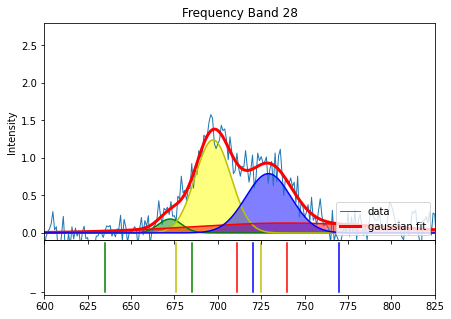

In [27]:
#Plot fill parameters
params1 = params[0:3]
params2 = params[3:6]
params3 = params[6:9]
params4 = params[9:12]
gfit1 = gauss(x, *params1)
gfit2 = gauss(x, *params2)
gfit3 = gauss(x, *params3)
gfit4 = gauss(x, *params4)
#Boundary parameters
yt=[0,1]
x1=[635,635]
x2=[685,685]
x3=[676,676]
x4=[725,725]
x5=[711,711]
x6=[740,740]
x7=[720,720]
x8=[770,770]

    
plot = py.figure(figsize=(7, 5))
grid = py.GridSpec(5, 1, hspace=0, wspace=0)
boundary = plot.add_subplot(grid[4, 0])
main_ax = plot.add_subplot(grid[0:4, 0], sharex=boundary)


main_ax.plot(x, y, lw=1, label='data')
main_ax.plot(x,fit,color='red',lw=3,label='gaussian fit')
main_ax.plot(x, gfit1, "g")
main_ax.fill_between(x, gfit1.min(), gfit1, facecolor="green", alpha=0.5)
main_ax.plot(x, gfit2, "y")
main_ax.fill_between(x, gfit2.min(), gfit2, facecolor="yellow", alpha=0.5)
main_ax.plot(x, gfit3, "r")
main_ax.fill_between(x, gfit3.min(), gfit3, facecolor="red", alpha=0.5)
main_ax.plot(x, gfit4, "b")
main_ax.fill_between(x, gfit4.min(), gfit4, facecolor="blue", alpha=0.5)
boundary.plot(x1,yt, "g", '--')
boundary.plot(x2,yt, "g", '--')
boundary.plot(x3,yt, "y", '--')
boundary.plot(x4,yt, "y", '--')
boundary.plot(x5,yt, "r", '--')
boundary.plot(x6,yt, "r", '--')
boundary.plot(x7,yt, "b", '--')
boundary.plot(x8,yt, "b", '--')

py.title("Frequency Band 28")

py.ylabel('Intensity')
py.xlabel('Frequency (Bins)')
main_ax.legend(loc='lower right')
boundary.label_outer()
main_ax.label_outer()
py.axis([600,825,-0.1,2.8])

(210.9375, 298.828125, -0.1, 2.8)

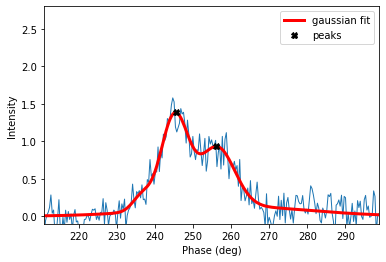

In [28]:
plot_peaks(x*(360/1024),y,profile_comp)
py.axis([210.9375,298.828125,-0.1,2.8])

#### EPN Profiles

In [29]:
#Takes a single frequency band out of all the profiles for analysis.
freqband = 0

f = j['frequency'] == freqband
x=j['phase'][f]
y=j['intensity'][f]

#Expected is taken from Peaks and Gaussian fittings of frequency band 73
expected1=(1,55,3,0.5,60,3)
bounds1=([0,0,0,0,0,0],[np.inf,j_phase,np.inf,np.inf,j_phase,np.inf])

noise = sigmaClip(y)
error = np.nanstd(noise[1])

#Fits three gaussians to the data
params, cov, sigma = fitting_parameters(x,y,expected1,bounds1)
fit = multi_gauss(x,*params)
#Then finds the maxima of the fit. It only takes the largest two (given they are the outer maxima).
#Error for the maxima position is calculated by finding the positions of the fit at an intensity-noise level
j_comp = fit_peaks(fit, freqband, cov, params,error,j_freq)
j_components = [j_comp]

[56.02017022 60.86188052]
[0.9860197  0.51831046]


In [30]:
#Takes a single frequency band out of all the profiles for analysis.
freqband = 0

f = wc['frequency'] == freqband
x=wc['phase'][f]
y=wc['intensity'][f]

#Expected is taken from Peaks and Gaussian fittings of frequency band 73
expected1=(0.1,470,10,0.6,505,3,0.4,550,3)
bounds1=([0,0,0,0,0,0,0,0,0],[np.inf,wc_phase,np.inf,np.inf,wc_phase,np.inf,np.inf,wc_phase,np.inf])

noise = sigmaClip(y)
error = np.nanstd(noise[1])

#Fits three gaussians to the data
params, cov, sigma = fitting_parameters(x,y,expected1,bounds1)
fit = multi_gauss(x,*params)
#Then finds the maxima of the fit. It only takes the largest two (given they are the outer maxima).
#Error for the maxima position is calculated by finding the positions of the fit at an intensity-noise level
wc_comp = gauss_peaks(fit, no_freq_bands, freqband, cov, params,minf,maxf,error,'epn',wc_freq)
wc_components = [wc_comp]

In [31]:
#Takes a single frequency band out of all the profiles for analysis.
freqband = 0

f = sgg['frequency'] == freqband
x=sgg['phase'][f]
y=sgg['intensity'][f]

#Expected is taken from Peaks and Gaussian fittings of frequency band 73
expected1=(40,225,10,100,400,5,60,550,3)
bounds1=([0,0,0,0,0,0,0,0,0],[np.inf,sgg_phase,np.inf,np.inf,sgg_phase,np.inf,np.inf,sgg_phase,np.inf])

noise = sigmaClip(y)
error = np.nanstd(noise[1])

#Fits three gaussians to the data
params, cov, sigma = fitting_parameters(x,y,expected1,bounds1)
fit = multi_gauss(x,*params)
#Then finds the maxima of the fit. It only takes the largest two (given they are the outer maxima).
#Error for the maxima position is calculated by finding the positions of the fit at an intensity-noise level
sgg1_comp = gauss_peaks(fit, no_freq_bands, freqband, cov, params,minf,maxf,error,'epn',sgg_freq)

<ipython-input-8-872f30e54463>:32: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))
<ipython-input-10-9957581a523b>:55: RuntimeWarning: divide by zero encountered in double_scalars
  if(max(peakint)/noise)>3:


In [32]:
#Takes a single frequency band out of all the profiles for analysis.
freqband = 1

f = sgg['frequency'] == freqband
x=sgg['phase'][f]
y=sgg['intensity'][f]

#Expected is taken from Peaks and Gaussian fittings of frequency band 73
expected1=(100,170,5,100,270,3)
bounds1=([0,0,0,0,0,0],[np.inf,sgg_phase,np.inf,np.inf,sgg_phase,np.inf])

noise = sigmaClip(y)
error = np.nanstd(noise[1])

#Fits three gaussians to the data
params, cov, sigma = fitting_parameters(x,y,expected1,bounds1)
fit = multi_gauss(x,*params)
#Then finds the maxima of the fit. It only takes the largest two (given they are the outer maxima).
#Error for the maxima position is calculated by finding the positions of the fit at an intensity-noise level
sgg2_comp = gauss_peaks(fit, no_freq_bands, freqband, cov, params,minf,maxf,error,'epn',sgg_freq)
sgg_components = [sgg1_comp,sgg2_comp]

In [33]:
#Takes a single frequency band out of all the profiles for analysis.
freqband = 0

f = hkk['frequency'] == freqband
x=hkk['phase'][f]
y=hkk['intensity'][f]

#Expected is taken from Peaks and Gaussian fittings of frequency band 73
expected1=(0.8,87,5,0.8,100,3)
bounds1=([0,0,0,0,0,0],[np.inf,hkk_phase,np.inf,np.inf,hkk_phase,np.inf])

noise = sigmaClip(y)
error = np.nanstd(noise[1])

#Fits three gaussians to the data
params, cov, sigma = fitting_parameters(x,y,expected1,bounds1)
fit = multi_gauss(x,*params)
#Then finds the maxima of the fit. It only takes the largest two (given they are the outer maxima).
#Error for the maxima position is calculated by finding the positions of the fit at an intensity-noise level
hkk_comp = gauss_peaks(fit, no_freq_bands, freqband, cov, params,minf,maxf,error,'epn',hkk_freq)
hkk_components = [hkk_comp]

[ 0.81358543 89.0201764   4.21280163  0.73601453 98.95715694  2.57399603]


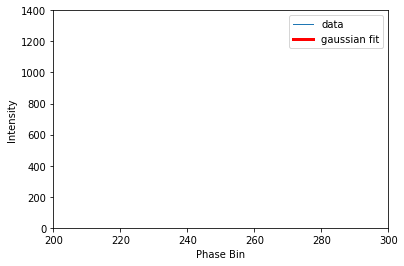

In [34]:
plot_fill(x,y,params)
py.axis([200,300,0,1400])
#py.axis([400,600,0,0.600])
#py.axis([60,120,0,0.9])
print(params)

pulse_component(frequency=728.2602163461538, comp1=component(phase=245.43496183377712, intensity=1.38522856126055), comp2=component(phase=256.08401064410486, intensity=0.9320688364860977), errors=array([0.24555205, 0.60566306]))


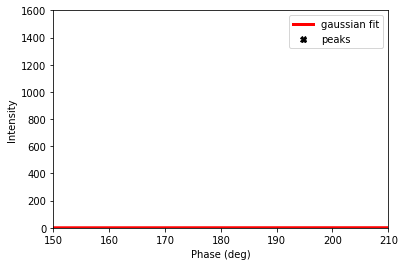

In [35]:
plot_peaks(x*(360/len(x)),y,profile_comp)
py.axis([150,210,0,1600])
print(profile_comp)

# ALL FREQUENCY BANDS

# Gaussian Plotting and Finding Peaks of Overall Fit


The following is a looped version of the previous section to find the correct peaks for each pulse profile

#### Parkes Data

In [36]:
fit_components = []
#Taken from Peaks and Gaussian fittings of frequency band 6, in the middle
#expected=(0.1,660,6,0.75,695,20,0.2,720,10,0.25,750,15)
expected1=(0.15,660,6,0.55,695,20,0.1,715,10,0.25,740,8)
bounds1=([0,625,0,0,675,0,0,712,0,0,720,0],[np.inf,675,np.inf,np.inf,725,np.inf,np.inf,740,np.inf,np.inf,760,np.inf])


#Loop thought all of the frequency bands
for i in range(0,no_freq_bands):
    freqband = i
    f = averageprofiles['frequency'] == freqband
    x=averageprofiles['phase'][f]
    y=averageprofiles['intensity'][f]
    
    noise = sigmaClip(y)
    error = np.nanstd(noise[1])

    #Fit the gaussians and find peaks and errors, create array with all frequencies
    #Resulting frequencies are in MHz and phase in degrees
    if len(x)!=0 and len(y)!=0:
        try:
            params,cov,sigma = fitting_parameters(x,y,expected1,bounds1)
            fit = multi_gauss(x,*params)
            profile_comp = gauss_peaks(fit, no_freq_bands, freqband, cov, params, minf,maxf,error)
        except:
            component1 = component(phase=0, intensity=0)
            component2 = component(phase=0, intensity=0)
            error = 0             
            freq=(((maxf-minf)/no_freq_bands)*(freqband))+minf+((maxf-minf)/(no_freq_bands*2))
            profile_comp = pulse_component(frequency=freq, comp1=component1, comp2=component2, errors=error)
        fit_components.append(profile_comp)

/home/lisasmith/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/lisasmith/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


peaks 1 [695.1903752163188] band 13
peaks 1 [697.4406731879283] band 17
Too noisey 19
peaks 2 [695.7652373640921, 724.0077890444836] band 19


<ipython-input-8-872f30e54463>:32: RuntimeWarning: invalid value encountered in double_scalars
  x_err.append(sigma_y / abs(d2dx2))


Too noisey 27
peaks 3 [696.8792029099967, 724.1849051189974, 745.2761795999654] band 27
peaks 2 [665.3708119623017, 699.9868893266478] band 40
peaks 2 [663.5072143424425, 700.3354098314603] band 41
peaks 2 [665.6965753411575, 699.1586427313864] band 42
peaks 2 [665.1886946366424, 698.8197716780141] band 43
peaks 2 [671.7547039187349, 698.6113860780306] band 46
peaks 1 [699.4109399567864] band 48
peaks 2 [669.6770550633455, 698.0181941309737] band 49
Too noisey 84
peaks 3 [630.4372763317735, 694.1685438687317, 712.9939782980159] band 84
Too noisey 91
peaks 3 [654.7655286962367, 693.9455114933372, 739.493437558425] band 91
peaks 3 [656.264441662287, 693.3764555162246, 714.5832228754517] band 92
Too noisey 93
peaks 4 [654.9246751704004, 696.7278196241699, 716.0217455150397, 759.9999999352427] band 93
Too noisey 100
peaks 4 [654.7757355412568, 699.3256893121479, 713.976622777012, 753.5241073241814] band 100
peaks 2 [665.1261986863319, 696.3174303100775] band 102
peaks 2 [666.1475938653189,

Too noisey 365
peaks 3 [676.5986485521906, 711.7977099613507, 753.7361671848188] band 365
Too noisey 366
peaks 3 [684.0209747669876, 713.4583551436373, 750.7207696342989] band 366
Too noisey 367
peaks 4 [661.8763705787884, 686.0767685078746, 710.06976221867, 749.5545454291903] band 367
Too noisey 371
peaks 3 [675.9373021848086, 711.694569483225, 759.8856738428819] band 371
Too noisey 372
peaks 4 [664.2549309012433, 685.7160019739664, 713.2335642391549, 753.7821496991393] band 372
Too noisey 373
peaks 3 [690.9229002668186, 714.9915205822379, 744.974281693598] band 373
Too noisey 374
peaks 3 [680.7693358845813, 711.9042233242071, 759.8759751690578] band 374
Too noisey 375
peaks 3 [675.6208741913636, 711.538146505998, 743.0869082139913] band 375
Too noisey 401
peaks 2 [687.3509558659276, 716.4512369858894] band 401
peaks 3 [665.8195307761046, 684.3384781012604, 710.820104893172] band 402
Too noisey 403
peaks 2 [684.0988002498848, 718.851755216109] band 403
Too noisey 404
peaks 4 [670.4317

Too noisey 511
peaks 3 [661.0532137571596, 699.3306753392036, 741.5375234984136] band 511
Too noisey 512
peaks 3 [693.473517788602, 711.2321045728495, 734.9804580041972] band 512
Too noisey 514
peaks 1 [701.5192391884823] band 514
Too noisey 515
peaks 3 [691.0549402987967, 709.3044057064125, 739.0133082086389] band 515
Too noisey 516
peaks 3 [660.1325775222577, 697.9970300519055, 740.5791300506784] band 516
Too noisey 517
peaks 4 [703.0326308502647, 722.1350120123116, 722.9533357242087, 725.9888876374126] band 517
peaks 2 [710.5259617961725, 741.9010720382439] band 518
Too noisey 520
peaks 3 [662.7076410550773, 703.3746205875482, 738.0171469850569] band 520
Too noisey 521
peaks 4 [666.5333071654902, 695.7395607424647, 711.299127794615, 738.5109366218522] band 521
Too noisey 522
peaks 3 [666.3611258479804, 710.7173958738714, 743.5978864372372] band 522
Too noisey 523
peaks 4 [625.0000897916082, 697.7482284533319, 711.5223857117334, 740.9841906115697] band 523
Too noisey 524
peaks 4 [674

peaks 3 [658.6676587681569, 698.790238064729, 715.6328885991047] band 667
peaks 1 [702.0824653262061] band 670
peaks 4 [660.5292546318454, 697.8850680474297, 709.1841248484113, 709.931647946057] band 677
Too noisey 683
peaks 4 [659.2182600251101, 696.6519235169704, 710.0049251391938, 738.5222122587444] band 683
Too noisey 685
peaks 4 [650.9180915559687, 698.3122829194572, 723.1726979851558, 735.6244211691579] band 685
Too noisey 686
peaks 4 [659.6509018403334, 700.0036472947804, 728.1174141780498, 742.5743894133183] band 686
Too noisey 687
peaks 3 [653.9465879457922, 704.8287291325809, 744.2920121441496] band 687
Too noisey 688
peaks 2 [707.3573276160647, 739.7982625143927] band 688
Too noisey 691
peaks 3 [695.6256406266995, 730.6964312279812, 756.6911272688986] band 691
Too noisey 692
peaks 4 [656.314364333083, 696.6490276781927, 719.1083878259233, 740.9384228832149] band 692
Too noisey 693
peaks 4 [662.054526174917, 694.0403421917686, 722.4268260513782, 745.7602750629388] band 693
To

peaks 2 [688.5300915535508, 701.7090362174839] band 814
Too noisey 815
peaks 3 [680.9336410678168, 703.9756781683237, 723.858884635165] band 815
Too noisey 816
peaks 2 [690.8534876430188, 739.1973077846791] band 816
Too noisey 817
peaks 3 [696.3741665697133, 716.3473130461864, 752.4227705543678] band 817
Too noisey 819
peaks 4 [650.4820544260211, 692.8251166683394, 728.123201734481, 741.9833599397883] band 819
Too noisey 820
peaks 3 [667.8675139370545, 690.4887800449171, 739.4283970944485] band 820
Too noisey 821
peaks 4 [659.1608408082298, 698.0840920891842, 738.7978952833812, 756.9085907391006] band 821
Too noisey 822
peaks 4 [666.0940063763594, 699.3238243995972, 724.5475421943127, 747.7147304336414] band 822
Too noisey 823
peaks 3 [661.3113963272432, 682.7826907931527, 728.1983992231915] band 823
Too noisey 824
peaks 4 [666.963383230361, 699.7342307379705, 720.7803661362506, 743.7227080349337] band 824
Too noisey 826
peaks 4 [645.6770045475907, 689.2024557064319, 714.6331327153138,

Too noisey 1052
peaks 4 [665.2427633159915, 704.6228844748642, 731.0736209242511, 746.617570242666] band 1052
Too noisey 1054
peaks 4 [670.6537068628841, 700.9209733269596, 726.2136502030212, 744.4034527849107] band 1054
Too noisey 1055
peaks 4 [660.2825437350347, 692.1990078262091, 725.9676493742239, 744.995705161551] band 1055
Too noisey 1056
peaks 3 [688.5981643494284, 729.8980500223688, 748.8893237191688] band 1056
peaks 16 [652.2194200698881, 713.5009917093821, 722.1886286756426, 722.9227043983385, 724.0194400322586, 724.994077269373, 726.0016984863017, 726.9995082500258, 728.0001408976981, 729.6540438131216, 731.9990287501994, 733.0038358484722, 733.9854909465887, 735.065228615889, 735.818175602883, 742.2662160584625] band 1057
Too noisey 1058
peaks 3 [657.5973301225907, 693.5491317741453, 726.4635976856781] band 1058
Too noisey 1059
peaks 4 [668.4890860831856, 699.9016622619339, 723.1017092677548, 751.9768372836534] band 1059
Too noisey 1060
peaks 4 [669.5504116068876, 688.34998

Too noisey 1202
peaks 4 [666.5462034536049, 695.3900247065679, 720.5973903386225, 736.0820227687666] band 1202
Too noisey 1203
peaks 3 [673.3238307329134, 715.4758150212215, 755.228571343238] band 1203
Too noisey 1204
peaks 4 [668.8823002541637, 699.2323722425474, 717.7169421061393, 737.4020959639182] band 1204
Too noisey 1205
peaks 4 [670.700660850553, 698.3902344399875, 725.8617153382553, 748.1502508535128] band 1205
Too noisey 1206
peaks 4 [670.9519477522678, 698.3423852107735, 715.6561172601273, 741.8557017927915] band 1206
Too noisey 1207
peaks 2 [692.8335729894836, 722.535564612348] band 1207
Too noisey 1208
peaks 4 [662.6715179815506, 692.0995713825248, 722.4132386068354, 747.1777652086033] band 1208
Too noisey 1209
peaks 4 [655.9363141429103, 689.2972031898956, 712.8110627101696, 741.9651949318858] band 1209
Too noisey 1210
peaks 4 [668.2962478215471, 688.4057601876211, 713.0306019181751, 746.0245525422658] band 1210
Too noisey 1211
peaks 4 [656.6919550737167, 698.1710193815807

Too noisey 1478
peaks 4 [657.2562994975289, 689.561471740365, 715.051688847604, 737.356843799434] band 1478
Too noisey 1479
peaks 3 [661.9562007152022, 682.4920679223674, 722.9796104594975] band 1479
Too noisey 1480
peaks 4 [643.1936537047889, 688.5558712392478, 727.1868394764394, 746.7056934103138] band 1480
Too noisey 1481
peaks 3 [668.6132198813684, 701.6315791274084, 757.2091941419584] band 1481
Too noisey 1482
peaks 3 [654.3653781072479, 693.034919280357, 753.8860875615854] band 1482
Too noisey 1483
peaks 4 [675.6759827614238, 691.0754357940102, 720.668524883385, 755.643427943907] band 1483
Too noisey 1484
peaks 4 [673.3529622169619, 696.2726489814847, 721.4115647139108, 747.0842205007219] band 1484
Too noisey 1485
peaks 3 [692.8141838536272, 713.532831795869, 744.3630851015104] band 1485
Too noisey 1487
peaks 4 [672.2914912382937, 696.4469246347611, 723.8822222507634, 756.2265433026319] band 1487
Too noisey 1488
peaks 4 [674.4345119479765, 700.8917025319969, 731.2492645543343, 75

Too noisey 1566
peaks 3 [675.942141974056, 718.8297423348059, 744.3406671085089] band 1566
Too noisey 1567
peaks 4 [654.3898422924519, 676.924249283526, 723.8615093090317, 746.2376456805747] band 1567
Too noisey 1568
peaks 3 [681.2816383211959, 716.8183640998972, 739.0874839944303] band 1568
Too noisey 1570
peaks 4 [661.3474936531534, 690.8930202138134, 731.8028801142675, 752.1662177414316] band 1570
Too noisey 1571
peaks 3 [695.180823134499, 729.1855660425775, 742.754982723469] band 1571
Too noisey 1572
peaks 3 [655.0130561429088, 702.7685266843905, 727.6135427033637] band 1572
Too noisey 1574
peaks 2 [662.6921278117578, 698.8935173395806] band 1574
Too noisey 1575
peaks 3 [681.2841125302328, 718.3497123401763, 740.0312110575486] band 1575
Too noisey 1577
peaks 4 [660.9029987994071, 678.667578884723, 733.0623555910047, 753.8369690371514] band 1577
Too noisey 1578
peaks 6 [656.8719092352247, 701.3099708363194, 716.5745818278903, 716.6620230370725, 721.9095868359602, 756.0339170399818] 

Too noisey 1716
peaks 4 [663.9627963488864, 680.3254135501196, 712.6771631772962, 729.1430900568248] band 1716
Too noisey 1717
peaks 3 [658.0851285622848, 713.1575536717834, 743.4702906134294] band 1717
Too noisey 1718
peaks 4 [657.8434809163632, 680.7837273940514, 711.9284600207766, 731.7986259995763] band 1718
peaks 3 [668.9795547562647, 718.7110270847568, 732.3462233201245] band 1719
Too noisey 1721
peaks 2 [681.2416846619137, 735.7370940065147] band 1721
Too noisey 1722
peaks 3 [640.2093704212501, 704.9316956342439, 737.998991349682] band 1722
Too noisey 1723
peaks 3 [688.9342003424019, 717.655544745161, 726.1289581710552] band 1723
peaks 3 [661.5257545684108, 684.7300387705179, 711.5891829046294] band 1724
Too noisey 1725
peaks 3 [689.5824178455224, 711.6937345037046, 738.1887006339887] band 1725
Too noisey 1726
peaks 4 [662.837069145354, 687.5085660734767, 721.8946005818108, 737.7504031400955] band 1726
Too noisey 1727
peaks 4 [657.7038932622075, 692.664092305723, 719.25832349450

Too noisey 1799
peaks 3 [686.0535358028679, 714.4842742688629, 736.7124793718916] band 1799
Too noisey 1800
peaks 4 [660.205809504821, 692.2611672293559, 724.9055163492787, 759.987021110519] band 1800
Too noisey 1801
peaks 3 [671.1932610959367, 700.8994784042642, 741.5223589190667] band 1801
Too noisey 1802
peaks 3 [689.6087737733144, 716.4545371289115, 759.7196232316484] band 1802
Too noisey 1803
peaks 2 [696.7329906427792, 753.9644393951802] band 1803
Too noisey 1804
peaks 4 [662.3602642746743, 684.369251757963, 714.0185358214338, 738.3484353329973] band 1804
Too noisey 1805
peaks 4 [660.8775659984267, 692.9547350020891, 713.8933423572164, 741.5086613887111] band 1805
Too noisey 1806
peaks 4 [672.1684741842024, 696.9932255011703, 723.8374200012067, 734.6702166791503] band 1806
Too noisey 1807
peaks 4 [663.214546881405, 692.4856543655116, 727.092897135775, 747.2149404572675] band 1807
Too noisey 1809
peaks 4 [673.4057238241123, 698.8412618406381, 727.5003216766302, 754.7100237072058] 

Too noisey 1888
peaks 4 [671.4257228030835, 688.9368026062432, 715.0765100668924, 753.8772056760387] band 1888
Too noisey 1889
peaks 3 [690.3663072071504, 717.8340503105801, 742.6882694148084] band 1889
peaks 7 [697.7583228945456, 709.4138134551913, 709.7889081543071, 711.0372178527574, 711.9889424370725, 713.0029112708896, 714.5430356629759] band 1890
Too noisey 1892
peaks 4 [654.3672685813968, 692.9412781257898, 723.4410829317956, 757.3851905399956] band 1892
Too noisey 1894
peaks 4 [670.2880700061037, 697.2492364760482, 715.5998110455592, 747.6522677333378] band 1894
Too noisey 1895
peaks 3 [698.074247282013, 720.0069637455122, 740.2605764931781] band 1895
Too noisey 1896
peaks 4 [656.4587428634517, 698.7016666513417, 733.0686605101405, 755.4546704904451] band 1896
Too noisey 1897
peaks 3 [632.3560026881148, 693.5672954503175, 733.1805999656716] band 1897
Too noisey 1898
peaks 3 [675.0678402427933, 694.9506095904177, 733.773840305323] band 1898
Too noisey 1899
peaks 3 [674.236523470

Too noisey 1989
peaks 4 [660.6686816195565, 689.305063153254, 723.7693890216098, 743.8392227147297] band 1989
Too noisey 1990
peaks 5 [673.0152487658394, 673.9492983551452, 690.3687610046364, 711.8541732420412, 738.3470160746475] band 1990
Too noisey 1991
peaks 4 [639.3948998620021, 689.0548401654287, 712.5094931750873, 741.6744363359136] band 1991
Too noisey 1992
peaks 3 [660.5865001190797, 693.237019122166, 727.5095038381384] band 1992
Too noisey 1994
peaks 3 [664.6130659957424, 691.0458196890858, 747.1168901470447] band 1994
Too noisey 1995
peaks 4 [654.1767143537389, 698.0379561865333, 725.8440659026182, 744.0488464671433] band 1995
Too noisey 1996
peaks 6 [661.7739418720569, 694.677357519607, 730.477294571909, 734.1046099930683, 734.9617031291216, 736.0097512802673] band 1996
Too noisey 1997
peaks 3 [661.7717894654647, 686.1955707716324, 749.9506963733237] band 1997
Too noisey 1998
peaks 3 [685.1847754134219, 712.4012438023079, 728.9001310560612] band 1998
Too noisey 1999
peaks 4 

Too noisey 2079
peaks 4 [664.5204882822112, 685.5051459654628, 712.6817408674322, 750.4127251092291] band 2079
Too noisey 2080
peaks 4 [667.2733340976104, 695.15862313019, 719.4586247340778, 746.5138567428493] band 2080
Too noisey 2081
peaks 3 [677.4202392721606, 693.1604152563937, 723.3029326193677] band 2081
Too noisey 2082
peaks 4 [667.2140392289797, 691.7767672674843, 711.5478492138566, 745.5951464110803] band 2082
Too noisey 2083
peaks 4 [655.0484027369115, 696.4487317469722, 735.5980429218005, 754.2802497592999] band 2083
Too noisey 2084
peaks 4 [671.4658595785878, 700.2461756160152, 731.2592908952386, 759.8941545893045] band 2084
Too noisey 2085
peaks 3 [663.4943122349149, 687.8735500014024, 744.3597525030668] band 2085
Too noisey 2086
peaks 4 [660.7674859271707, 686.9947397727947, 718.4539022268755, 741.6551555420609] band 2086
Too noisey 2087
peaks 5 [675.5045282541759, 705.6478871697859, 730.0259856575819, 730.9186483519794, 745.1149537604282] band 2087
Too noisey 2088
peaks 

Too noisey 2165
peaks 4 [674.7363260095655, 706.9181759459586, 731.2497091691745, 746.358337633048] band 2165
Too noisey 2167
peaks 2 [693.6127232565907, 744.2629349916821] band 2167
Too noisey 2168
peaks 4 [663.2003953534875, 693.4384781846969, 715.2184386719365, 742.7876134779387] band 2168
Too noisey 2169
peaks 4 [660.5974421358528, 690.9284428614635, 724.7134491707764, 744.4541417248604] band 2169
Too noisey 2171
peaks 4 [662.4316826005921, 693.9284266860096, 718.3808062191277, 738.181129529099] band 2171
Too noisey 2172
peaks 3 [663.5137127538537, 690.7733850041992, 751.733573294749] band 2172
Too noisey 2173
peaks 3 [667.7963410181263, 708.9471176850121, 743.877367696089] band 2173
Too noisey 2174
peaks 4 [656.2955616406146, 697.2071399886246, 738.2152834723084, 752.9983911655567] band 2174
Too noisey 2175
peaks 3 [694.653023726629, 708.863715328201, 742.3555562397778] band 2175
Too noisey 2176
peaks 3 [674.5758118452966, 694.2051984317311, 740.6903173814629] band 2176
Too noisey

Too noisey 2299
peaks 4 [666.5660133587122, 691.415417053465, 714.0815917828234, 729.8381314871731] band 2299
peaks 3 [664.3910830196444, 692.4631422586297, 713.241663645266] band 2300
Too noisey 2301
peaks 4 [659.5436376944323, 694.2829857484146, 728.2445194845678, 748.4569987248063] band 2301
Too noisey 2302
peaks 3 [666.5913399355293, 691.0679583316216, 742.3189119955993] band 2302
Too noisey 2303
peaks 3 [663.2770102936988, 686.808651636649, 749.8331885806484] band 2303
Too noisey 2304
peaks 6 [661.7935297164653, 697.4599703248723, 711.1685653071703, 711.938219359852, 713.014481135624, 740.4905303035206] band 2304
Too noisey 2305
peaks 3 [664.0728892908819, 695.86240057449, 737.570225464663] band 2305
Too noisey 2306
peaks 4 [655.8215738383124, 695.0787622628383, 711.5736195369847, 741.5134677755445] band 2306
Too noisey 2307
peaks 4 [657.6776609910688, 690.4877997620542, 715.7620983911984, 740.3729175843727] band 2307
Too noisey 2308
peaks 3 [661.3886021047185, 691.0369018169126, 

Too noisey 2429
peaks 3 [692.8772969775703, 725.45703263769, 755.3830518335275] band 2429
Too noisey 2431
peaks 3 [663.1882329774342, 696.0764313010687, 713.6243587234793] band 2431
Too noisey 2432
peaks 4 [663.8839811034948, 698.1786772066548, 727.9404804035464, 747.6885808375489] band 2432
Too noisey 2433
peaks 3 [691.6730870643062, 722.2898954679814, 746.2501221581969] band 2433
Too noisey 2434
peaks 3 [691.603552064088, 725.4328148979837, 755.3258328475291] band 2434
Too noisey 2435
peaks 4 [665.177921008631, 696.9873551072058, 712.9561177577873, 745.8223795120975] band 2435
Too noisey 2436
peaks 4 [668.8696692601072, 694.0172817487571, 716.3236933355165, 739.2931205990213] band 2436
Too noisey 2437
peaks 5 [664.0637556268622, 665.2432571569984, 693.5737319677604, 727.7625652790819, 753.6851356244396] band 2437
Too noisey 2438
peaks 3 [692.7268614942836, 710.0631755883048, 738.667616470429] band 2438
Too noisey 2439
peaks 4 [652.7560743907313, 689.0971468233964, 707.4795189242744, 

Too noisey 2527
peaks 4 [664.3054076905663, 689.8790111704024, 719.642824875352, 742.1643321172692] band 2527
Too noisey 2529
peaks 4 [659.9604341630638, 693.0609112416471, 733.2788178451078, 746.0309218863844] band 2529
Too noisey 2530
peaks 2 [697.5516589537864, 752.0875985710726] band 2530
Too noisey 2531
peaks 3 [685.0976165769142, 706.3818659325888, 741.0677598699704] band 2531
Too noisey 2532
peaks 3 [676.8814090009212, 696.616865915508, 739.22285419229] band 2532
Too noisey 2533
peaks 6 [667.2202888883154, 699.4102545096043, 709.488087959831, 709.7370177641934, 712.9635172516571, 746.4458743443548] band 2533
Too noisey 2534
peaks 4 [664.3203279197079, 687.4698995431274, 712.5915032357366, 740.672704193766] band 2534
Too noisey 2535
peaks 4 [667.4160248671495, 697.232732977345, 711.820197604602, 746.0881118206617] band 2535
Too noisey 2536
peaks 2 [656.6775050412979, 697.1263077409216] band 2536
Too noisey 2537
peaks 2 [662.9333241665217, 695.7083849903617] band 2537
Too noisey 2

Too noisey 2617
peaks 3 [688.3780460207898, 728.4350317188764, 743.0732381882723] band 2617
Too noisey 2618
peaks 4 [675.1422115649948, 699.9966494100191, 718.3229530361046, 737.6960998310736] band 2618
Too noisey 2621
peaks 9 [652.3080132542584, 696.0144208524207, 707.3101918543036, 707.8598598804383, 709.0285883293145, 709.9917281860482, 711.0021924222914, 712.9978365126946, 759.7810829580653] band 2621
Too noisey 2623
peaks 11 [663.8701223263179, 689.052272872733, 723.995832661715, 725.0296046614943, 725.9838599978517, 727.0062348526833, 727.997765502101, 729.0007169863745, 732.995972570516, 734.0171023548409, 734.9391492751203] band 2623
Too noisey 2624
peaks 4 [667.3301429791486, 684.6720724327115, 725.8927976025938, 746.4009762984024] band 2624
Too noisey 2625
peaks 4 [655.0653291341669, 698.7183755949025, 737.8054866636456, 749.0255343263697] band 2625
Too noisey 2627
peaks 3 [655.4288519185812, 691.5462900458829, 759.8933656516065] band 2627
Too noisey 2628
peaks 4 [666.9961706

Too noisey 2705
peaks 4 [670.3154897998429, 693.317931931523, 711.9660184549736, 735.532975873483] band 2705
Too noisey 2706
peaks 4 [663.1968258140474, 691.6994603615111, 713.5707282254807, 744.2793795443544] band 2706
Too noisey 2707
peaks 4 [661.9114000227481, 689.2261646208573, 718.2519093042032, 748.3412562565761] band 2707
Too noisey 2708
peaks 3 [649.6456317367293, 686.212420681361, 744.5268256217153] band 2708
Too noisey 2709
peaks 4 [659.4370338732243, 692.8906966726158, 728.1164183995758, 746.6124277726785] band 2709
Too noisey 2710
peaks 4 [655.8795662052107, 693.3304376540653, 720.5247667595686, 748.2446270852205] band 2710
Too noisey 2711
peaks 4 [656.7153900997616, 689.0903096350602, 732.5642675940842, 749.6723083382678] band 2711
Too noisey 2712
peaks 4 [664.1906682510945, 692.1093960735652, 715.6917545610711, 753.0117885800752] band 2712
Too noisey 2713
peaks 3 [673.4780143371734, 696.9321475286574, 739.9614614451647] band 2713
Too noisey 2714
peaks 5 [672.0830982922752

Too noisey 2788
peaks 3 [659.6182367058072, 690.6992188512085, 749.4259499693079] band 2788
Too noisey 2790
peaks 4 [663.5897832968407, 693.2550335550403, 736.4603259472009, 757.6681400375967] band 2790
Too noisey 2791
peaks 2 [650.8596817680622, 694.7848970272414] band 2791
Too noisey 2793
peaks 4 [671.7842281460773, 695.2595755292683, 731.8172737192298, 743.6861947433678] band 2793
Too noisey 2794
peaks 3 [659.0293957858594, 693.5211722419222, 740.8483512573459] band 2794
Too noisey 2795
peaks 4 [664.4988496755182, 690.481522971381, 712.171310683218, 732.2185433291415] band 2795
Too noisey 2796
peaks 4 [661.0359791849828, 691.3772966434472, 713.4720043890857, 742.5920984711599] band 2796
Too noisey 2797
peaks 4 [662.8998256765884, 688.8859932683821, 716.0020447061355, 741.9575252725838] band 2797
Too noisey 2798
peaks 3 [693.3470628132495, 718.6050973072454, 725.8732543709999] band 2798
Too noisey 2800
peaks 4 [665.0538842570564, 687.3168883901025, 712.148861599125, 753.1120277729278

Too noisey 2881
peaks 3 [649.3276808951848, 683.8859218859916, 723.8452402742556] band 2881
Too noisey 2882
peaks 3 [659.7019550264192, 696.1390298962954, 753.9607740447184] band 2882
Too noisey 2883
peaks 4 [654.9505290877297, 681.7629780151253, 715.270301466891, 751.9323307823727] band 2883
Too noisey 2884
peaks 4 [652.7949156591659, 680.8715401463734, 710.559435137189, 750.9092584437757] band 2884
Too noisey 2885
peaks 4 [671.2011524396356, 697.292272323337, 726.0341946979695, 744.2944102746029] band 2885
Too noisey 2886
peaks 4 [658.2294183512099, 697.3285886855042, 723.62898462871, 759.9165957422589] band 2886
Too noisey 2887
peaks 3 [664.7080991463906, 692.4590227494664, 751.7804777770339] band 2887
Too noisey 2888
peaks 4 [658.3126426076062, 695.9577918566553, 733.0411187885587, 747.4969822869252] band 2888
Too noisey 2889
peaks 2 [689.529205921857, 728.2345464457386] band 2889
Too noisey 2890
peaks 4 [663.2220887589539, 684.5329646903355, 710.4809527182877, 738.704911964661] ba

Too noisey 2967
peaks 4 [661.1468895783944, 691.3958126266954, 716.4106163999955, 731.2213075152225] band 2967
Too noisey 2968
peaks 4 [653.8607509820073, 702.7882519529729, 732.4349598117469, 743.378340799606] band 2968
Too noisey 2969
peaks 3 [667.4919066373004, 699.7319016668645, 747.3411210505066] band 2969
Too noisey 2970
peaks 4 [665.1899009477886, 688.7669400301097, 725.2389077321927, 746.9021236761054] band 2970
Too noisey 2971
peaks 3 [662.00071132792, 697.8433142477847, 747.3331112143278] band 2971
Too noisey 2972
peaks 4 [667.5320221941923, 687.5568389362699, 716.2182305617836, 754.1092168256296] band 2972
Too noisey 2973
peaks 3 [675.4671347298105, 689.5113688839937, 743.1869150998051] band 2973
Too noisey 2974
peaks 3 [661.3109879850061, 688.6838929273035, 745.8494609252118] band 2974
Too noisey 2975
peaks 5 [662.9951694484441, 698.6727669944272, 726.0139911191651, 726.9528685040663, 759.999164082887] band 2975
Too noisey 2976
peaks 4 [662.7877156365925, 699.4200714554923,

Too noisey 3047
peaks 2 [661.5811621634876, 707.2064047421757] band 3047
Too noisey 3048
peaks 4 [662.0806174506035, 696.964534737767, 714.8748545665676, 743.2132175616225] band 3048
Too noisey 3049
peaks 4 [667.7560705073917, 700.0685148733843, 725.9427712619729, 748.4176985471825] band 3049
Too noisey 3050
peaks 3 [649.1492331774372, 686.8434393867417, 753.8098691168847] band 3050
Too noisey 3051
peaks 4 [652.263490341272, 694.0429246659343, 722.8531567831709, 749.5260202712263] band 3051
Too noisey 3052
peaks 4 [666.7197567692108, 682.3235701875112, 727.3741724690442, 743.3310722107552] band 3052
Too noisey 3053
peaks 4 [632.1494462809037, 677.5565155154951, 711.8007738486846, 751.6160113833932] band 3053
Too noisey 3054
peaks 3 [654.3117020232853, 687.1623954149455, 739.0965327793891] band 3054
Too noisey 3055
peaks 4 [662.9356644088288, 694.122610360295, 727.5852169557104, 749.4798010753015] band 3055
Too noisey 3056
peaks 4 [667.5883543401078, 701.1480736873201, 727.5113216808938

Too noisey 3145
peaks 2 [697.3707728525519, 732.9456687554613] band 3145
Too noisey 3146
peaks 4 [658.0208514176184, 697.319402055557, 729.5095586143639, 739.8585726120581] band 3146
Too noisey 3147
peaks 3 [656.4229994466226, 691.1039954277558, 725.3324810431167] band 3147
Too noisey 3148
peaks 3 [684.9142961703652, 717.0353186638132, 738.122894932262] band 3148
Too noisey 3149
peaks 4 [654.9484859087154, 695.351369634771, 724.0891265635166, 746.5372104527335] band 3149
Too noisey 3150
peaks 2 [669.56065838745, 700.7992061530424] band 3150
Too noisey 3151
peaks 5 [711.3852384404073, 720.3126649561149, 720.8616666602967, 723.6183339766127, 747.218723795102] band 3151
Too noisey 3152
peaks 3 [688.1583913862813, 720.3046315609968, 739.3627887837015] band 3152
Too noisey 3153
peaks 4 [659.1710075454122, 684.0604811959403, 729.715928122788, 747.7580015521378] band 3153
Too noisey 3154
peaks 4 [650.3540424519557, 695.3318825334485, 734.0455678007571, 749.7006903678648] band 3154
Too noisey 

Too noisey 3231
peaks 4 [660.9263864983112, 693.7775928856055, 722.8961621112318, 747.3228418381223] band 3231
Too noisey 3232
peaks 3 [658.9165349355317, 708.0130174394747, 757.4069005435608] band 3232
Too noisey 3233
peaks 3 [656.0378999147458, 694.7205459014366, 744.7384591525106] band 3233
Too noisey 3234
peaks 3 [661.6135068430474, 695.003255908166, 741.1763925418743] band 3234
Too noisey 3235
peaks 3 [696.604050984057, 733.220569658524, 758.8787408432582] band 3235
Too noisey 3237
peaks 4 [656.5436275632833, 679.4245018851315, 712.6351019551433, 727.5762598870896] band 3237
Too noisey 3238
peaks 3 [669.8850491886939, 691.5350614925229, 733.2333676516422] band 3238
Too noisey 3240
peaks 4 [674.0397579278538, 685.4261044285669, 715.6424167709919, 742.7463886266917] band 3240
Too noisey 3241
peaks 4 [652.0252676775175, 688.2189441065815, 716.1417968109014, 739.5227015886173] band 3241
Too noisey 3242
peaks 4 [665.1529957071298, 696.4478293539794, 717.2150688950017, 741.1020445649841

Too noisey 3316
peaks 4 [664.8994442856751, 706.9336847968505, 728.0248090660281, 739.9394603331519] band 3316
Too noisey 3317
peaks 4 [652.5279034706081, 685.3725976926971, 721.7770695618375, 736.4202867067135] band 3317
Too noisey 3318
peaks 3 [668.0604657314367, 701.5998064511325, 739.9999600688731] band 3318
Too noisey 3320
peaks 3 [654.5800650827405, 685.477103779572, 722.892620842028] band 3320
Too noisey 3322
peaks 3 [656.3536152654995, 698.9054549191022, 759.0] band 3322
Too noisey 3324
peaks 3 [672.8828615016922, 701.8782325056468, 731.4914714071607] band 3324
Too noisey 3325
peaks 4 [660.2878798339065, 689.2303559526654, 728.0551500174039, 758.7068306131628] band 3325
Too noisey 3326
peaks 3 [702.4696960908211, 726.9571480813688, 738.7355053680182] band 3326
Too noisey 3327
peaks 4 [658.2172792844733, 698.3490921084225, 728.394451148635, 746.2589600285132] band 3327


#### EPN Data

In [37]:
ant_components = []
expected1=(1,85,3,0.6,90,3)
bounds1=([0,0,0,0,88,0],[np.inf,ant_phase,np.inf,np.inf,ant_phase,np.inf])

#Loop thought all of the frequency bands
for i in range(0,len(ant_freq)):
    freqband = i
    f = ant['frequency'] == freqband
    x=ant['phase'][f]
    y=ant['intensity'][f]
    
    noise = sigmaClip(y)
    error = np.nanstd(noise[1])

    #Fit the gaussians and find peaks and errors, create array with all frequencies
    #Resulting frequencies are in MHz and phase in degrees
    if len(x)!=0 and len(y)!=0:
        try:
            params,cov,sigma = fitting_parameters(x,y,expected1,bounds1)
            fit = multi_gauss(x,*params)
            profile_comp = fit_peaks(fit, freqband, cov, params,error,ant_freq)
        except:
            component1 = component(phase=0, intensity=0)
            component2 = component(phase=0, intensity=0)
            error = 0             
            freq=(((maxf-minf)/no_freq_bands)*(freqband))+minf+((maxf-minf)/(no_freq_bands*2))
            profile_comp = pulse_component(frequency=freq, comp1=component1, comp2=component2, errors=error)
        ant_components.append(profile_comp)

[86.35760633 91.02295404]
[0.92552287 0.40126563]
[86.23853255 91.45039212]
[0.98331631 0.54380821]
[86.22038573 91.75556784]
[1.00296912 0.633054  ]
[85.95008795 91.7502448 ]
[0.97003564 0.5848141 ]


In [38]:
gl_components = []
expected1=(200,210,3,1500,220,5,600,240,7)
bounds1=([0,0,0,0,0,0,0,0,0],[np.inf,gl_phase,np.inf,np.inf,gl_phase,np.inf,np.inf,gl_phase,np.inf])

#Loop thought all of the frequency bands
for i in range(0,2):
    freqband = i
    f = gl['frequency'] == freqband
    x=gl['phase'][f]
    y=gl['intensity'][f]
    
    noise = sigmaClip(y)
    error = np.nanstd(noise[1])

    #Fit the gaussians and find peaks and errors, create array with all frequencies
    #Resulting frequencies are in MHz and phase in degrees
    if len(x)!=0 and len(y)!=0:
        try:
            params,cov,sigma = fitting_parameters(x,y,expected1,bounds1)
            fit = multi_gauss(x,*params)
            profile_comp = fit_peaks(fit, freqband, cov, params,error,gl_freq)
        except:
            component1 = component(phase=0, intensity=0)
            component2 = component(phase=0, intensity=0)
            error = 0             
            freq=(((maxf-minf)/no_freq_bands)*(freqband))+minf+((maxf-minf)/(no_freq_bands*2))
            profile_comp = pulse_component(frequency=freq, comp1=component1, comp2=component2, errors=error)
        gl_components.append(profile_comp)

[222.77161072 223.84233694 237.68815482]
[1525.2518016  1553.24928419  625.30054279]
0
[214.77115133 230.97477944 248.14453084]
[123.85137889 620.32396069 321.32508712]
0


In [39]:
expected1=(100,230,3,1000,240,5,500,260,7)
bounds1=([0,0,0,0,0,0,0,0,0],[np.inf,gl_phase,np.inf,np.inf,gl_phase,np.inf,np.inf,gl_phase,np.inf])

#Loop thought all of the frequency bands
for i in range(2,4):
    freqband = i
    f = gl['frequency'] == freqband
    x=gl['phase'][f]
    y=gl['intensity'][f]
    
    noise = sigmaClip(y)
    error = np.nanstd(noise[1])

    #Fit the gaussians and find peaks and errors, create array with all frequencies
    #Resulting frequencies are in MHz and phase in degrees
    if len(x)!=0 and len(y)!=0:
        try:
            params,cov,sigma = fitting_parameters(x,y,expected1,bounds1)
            fit = multi_gauss(x,*params)
            profile_comp = fit_peaks(fit, freqband, cov, params,error,gl_freq)
        except:
            component1 = component(phase=0, intensity=0)
            component2 = component(phase=0, intensity=0)
            error = 0             
            freq=(((maxf-minf)/no_freq_bands)*(freqband))+minf+((maxf-minf)/(no_freq_bands*2))
            profile_comp = pulse_component(frequency=freq, comp1=component1, comp2=component2, errors=error)
        gl_components.append(profile_comp)

[222.50226148 239.03998507 257.861662  ]
[ 249.90583203 1157.80826511  715.4809543 ]
0
[227.15616563 243.30267316 263.03545319]
[134.39982169 357.00125166 238.20775962]
0


# Change of Peak Position over Frequency

Starting to graph out all the movement of component phase across frequency

## GMRT

### Component 1

<ErrorbarContainer object of 3 artists>

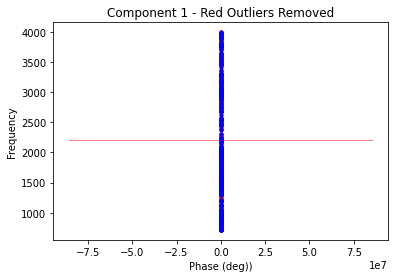

In [40]:
#Separate the array into x and y axis of phase and frequency which can be graphed
phase_comp1, frequency_comp1, comp1_err=graphing_comp(fit_components,1)
#Plot points
py.errorbar(phase_comp1,frequency_comp1, xerr=comp1_err, fmt='.', lw=0.5, color='red', label='data')
py.title('Component 1 - Red Outliers Removed')
py.xlabel('Phase (deg))')
py.ylabel('Frequency')
#Remove outliers which are greater than 'threshold' number of std away from the mean
frequency_comp1, phase_comp1, comp1_err = detect_outlier(frequency_comp1, phase_comp1, comp1_err,2)
#Plot outlier removed points"
py.errorbar(phase_comp1,frequency_comp1, xerr=comp1_err, fmt='.', lw=0.5, color='blue',label='data')

In [41]:
#Fit the thorsett model to the component position
y_range=list(range(700,4040))

#Fit a powerlaw to component position
comp1_paramspl,comp1_covpl=curve_fit(powerlaw,frequency_comp1,phase_comp1, maxfev=10000, sigma=comp1_err)
comp1_fit_errorpl=np.sqrt(np.diag(comp1_covpl))
comp1_fitpl = powerlaw(y_range, *comp1_paramspl)
comp1_fitpl2 = powerlaw(frequency_comp1, *comp1_paramspl)

#Fit a linear 
comp1_paramslin,comp1_covlin=curve_fit(linear,frequency_comp1,phase_comp1, maxfev=10000, sigma=comp1_err)
comp1_fit_errorlin=np.sqrt(np.diag(comp1_covlin))
comp1_fitlin = linear(y_range, *comp1_paramslin)
comp1_fitlin2 = linear(frequency_comp1, *comp1_paramslin)

#Residuals
comp1_resid_lin = phase_comp1 - comp1_fitlin2

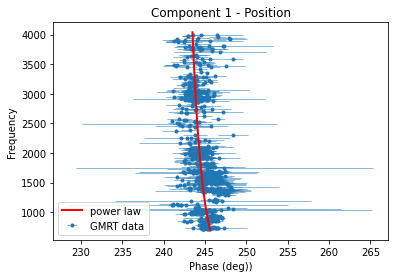

In [42]:
#Graph points with the fit ontop
py.errorbar(phase_comp1,frequency_comp1, xerr=comp1_err, fmt='.', lw=0.5, label='GMRT data', zorder=0)
py.plot(comp1_fitpl, y_range,color='red',lw=2, label='power law', zorder=1)
py.title('Component 1 - Position')
py.xlabel('Phase (deg))')
py.ylabel('Frequency')
py.legend(loc='lower left')

In [43]:
print(f'The power law equation of fit for this pulse is: \t Phase = {comp1_paramspl[0]:.3f} \u03BD^{comp1_paramspl[1]:.3f}')
print(f'The errors are {comp1_fit_errorpl[0]}, {comp1_fit_errorpl[1]}')

print(f'The power law equation of fit for this pulse is: \t Phase = {comp1_paramslin[0]:.6f} \u03BD +{comp1_paramslin[1]:.3f}')
print(f'The errors are {comp1_fit_errorlin[0]}, {comp1_fit_errorlin[1]}')

The power law equation of fit for this pulse is: 	 Phase = 253.738 ν^-0.005
The errors are 0.6587042116232876, 0.0003553794572172007
The power law equation of fit for this pulse is: 	 Phase = -0.000657 ν +245.802
The errors are 5.172726959817134e-05, 0.09719757465073593


In [44]:
print('The chi squared reduced value is', chsq_err(phase_comp1, comp1_fitpl2, comp1_err)/(len(phase_comp1)-2))

The chi squared reduced value is 6.013120248987619


### Component 2

<ErrorbarContainer object of 3 artists>

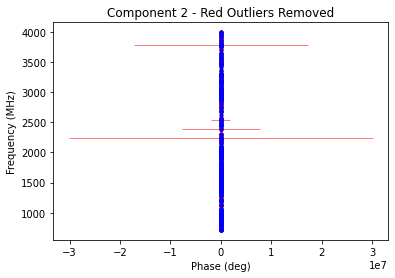

In [45]:
#Separate the array into x and y axis of phase and frequency which can be graphed
phase_comp2, frequency_comp2, comp2_err=graphing_comp(fit_components,2)
#Plot points
py.errorbar(phase_comp2,frequency_comp2, xerr=comp2_err, fmt='.', lw=0.5, color='red', label='data')
py.title('Component 2 - Red Outliers Removed')
py.xlabel('Phase (deg)')
py.ylabel('Frequency (MHz)')

#Remove outliers which are greater than 'threshold' number of std away from the mean
frequency_comp2, phase_comp2, comp2_err = detect_outlier(frequency_comp2, phase_comp2, comp2_err,2)
#Plot outlier removed points
py.errorbar(phase_comp2,frequency_comp2, xerr=comp2_err, fmt='.', lw=0.5, color='blue',label='data')

In [46]:
#Temporary for viewing
#print(comp2_err)
#ind=comp2_err.index(0)
#del comp2_err[ind]
#del phase_comp2[ind]
#del frequency_comp2[ind]

In [47]:
#Fit a powerlaw to the component position
comp2_paramspl,comp2_covpl=curve_fit(powerlaw,frequency_comp2,phase_comp2, maxfev=10000, sigma=comp2_err)
comp2_fit_errorpl=np.sqrt(np.diag(comp2_covpl))
comp2_fitpl = powerlaw(y_range, *comp2_paramspl)
comp2_fitpl2 = powerlaw(frequency_comp2, *comp2_paramspl)

#Fit a linear 
comp2_paramslin,comp2_covlin=curve_fit(linear,frequency_comp2,phase_comp2, maxfev=10000, sigma=comp2_err)
comp2_fit_errorlin=np.sqrt(np.diag(comp2_covlin))
comp2_fitlin = linear(y_range, *comp2_paramslin)
comp2_fitlin2 = linear(frequency_comp2, *comp2_paramslin)

#Residuals
comp2_resid_lin = phase_comp2 - comp2_fitlin2

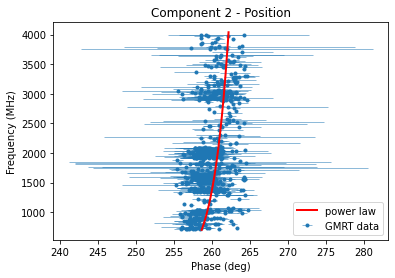

In [48]:
#Graph points with the fit ontop
py.errorbar( phase_comp2,frequency_comp2, xerr=comp2_err, fmt='.', lw=0.5, label='GMRT data', zorder=0)
py.plot(comp2_fitpl,y_range, color='red',lw=2, label='power law', zorder=1)
py.title('Component 2 - Position')
py.xlabel('Phase (deg)')
py.ylabel('Frequency (MHz)')
py.legend(loc='lower right')

In [49]:
print(f'The power law equation of fit for this pulse is: \t Phase = {comp2_paramspl[0]:.3f} \u03BD^{comp2_paramspl[1]:.3f}')
print(f'The errors are {comp2_fit_errorpl[0]}, {comp2_fit_errorpl[1]}')

print(f'The power law equation of fit for this pulse is: \t Phase = {comp2_paramslin[0]:.5f} \u03BD +{comp2_paramslin[1]:.3f}')
print(f'The errors are {comp2_fit_errorlin[0]}, {comp2_fit_errorlin[1]}')

The power law equation of fit for this pulse is: 	 Phase = 245.819 ν^0.008
The errors are 0.9899948916932286, 0.0005221541067255981
The power law equation of fit for this pulse is: 	 Phase = 0.00093 ν +258.683
The errors are 6.872425721659794e-05, 0.1791423743838537


In [50]:
print('The chi squared reduced value is',chsq_err(phase_comp2, comp2_fitpl2, comp2_err)/(len(phase_comp2)-2))

The chi squared reduced value is 18.83972879004016


# Both Component Movements

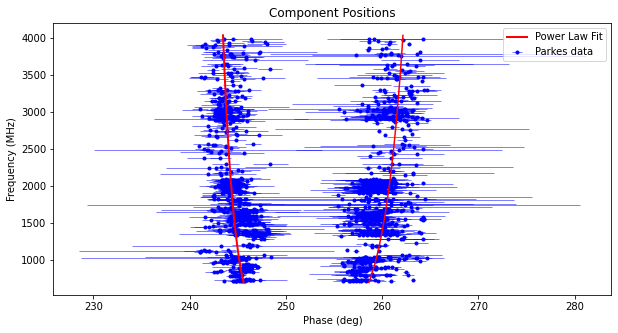

In [51]:
py.figure(figsize=(10,5))
py.errorbar(phase_comp2,frequency_comp2, xerr=comp2_err, color='blue', fmt='.', lw=0.5, label='Parkes data', zorder=0)
py.errorbar(phase_comp1,frequency_comp1, xerr=comp1_err, color='blue', fmt='.', lw=0.5, zorder=0)
py.plot(comp1_fitpl,y_range, color='red',lw=2, label='Power Law Fit', zorder=1)
py.plot(comp2_fitpl,y_range, color='red', zorder=1)
py.title('Component Positions')
py.xlabel('Phase (deg)')
py.ylabel('Frequency (MHz)')
py.legend()

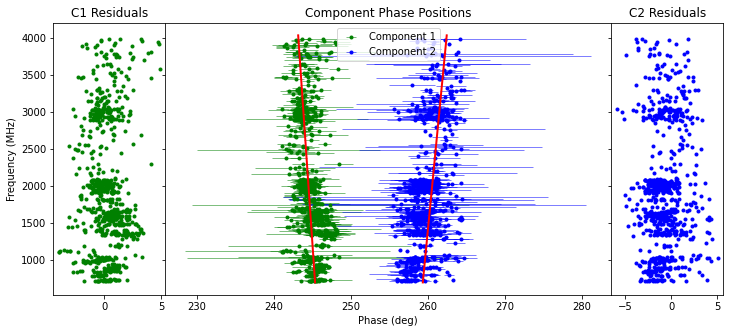

In [52]:
fig = py.figure(figsize=(12, 5))
grid = py.GridSpec(1, 6, hspace=0, wspace=0)
resid_1 = fig.add_subplot(grid[0, 0])
py.ylabel('Frequency (MHz)')
main_ax = fig.add_subplot(grid[0, 1:5], sharey=resid_1)
py.xlabel('Phase (deg)')
resid_2 = fig.add_subplot(grid[0, 5], sharey=resid_1)

resid_1.plot(comp1_resid_lin, frequency_comp1, '.', color='g')
main_ax.errorbar(phase_comp1,frequency_comp1, xerr=comp1_err, color='green', fmt='.', lw=0.5, label='Component 1', zorder=0)
main_ax.errorbar(phase_comp2,frequency_comp2, xerr=comp2_err, color='blue', fmt='.', lw=0.5, label='Component 2', zorder=0)
main_ax.plot(comp1_fitlin,y_range, color='red',lw=2, zorder=1)
main_ax.plot(comp2_fitlin,y_range, color='red',lw=2, zorder=1)
resid_2.plot(comp2_resid_lin, frequency_comp2, '.', color='b')

resid_1.set_title('C1 Residuals')
resid_2.set_title('C2 Residuals')
main_ax.set_title('Component Phase Positions')

main_ax.legend(loc='upper center')
resid_1.label_outer()
main_ax.label_outer()
resid_2.label_outer()


# Fitting Power Laws to Separation 

## Just Parkes

In [53]:
#Gain component separation values
component_sep, sep_error = separation_singleprofile(fit_components)

comp_sep=[]
frequency_forsep=[]

#Put them into arrays for graphing
for i in range(0,len(component_sep)):
    comp_sep.append(component_sep[i][1])
    frequency_forsep.append(component_sep[i][0])

Text(0.5, 1.0, 'Component Separation - Red Outliers Removed')

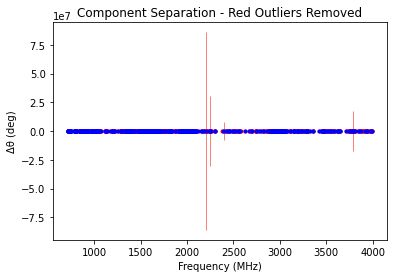

In [54]:
#Plot points
py.errorbar(frequency_forsep, comp_sep, yerr=sep_error, color='red', fmt='.', lw=0.5, label='data')
py.xlabel('Frequency (MHz)')
py.ylabel('\u0394\u03B8 (deg)')

#Remove outliers
frequency_forsep, comp_sep, sep_error = detect_outlier(frequency_forsep, comp_sep, sep_error, 2.5)

#Plot points with outliers removed
py.errorbar(frequency_forsep, comp_sep, yerr=sep_error, color='blue', fmt='.', lw=0.5, label='data')
py.title('Component Separation - Red Outliers Removed')

In [55]:
#Create a thorsett fit
expect=(703,0.5,10)
sep_params,sep_cov=curve_fit(thorsett,frequency_forsep,comp_sep, expect, maxfev=10000, sigma=sep_error, bounds=([0,-1,-np.inf],[np.inf,0.5,np.inf]))
sep_fit_error=np.sqrt(np.diag(sep_cov))
separation_fit=thorsett(frequency_forsep,*sep_params)

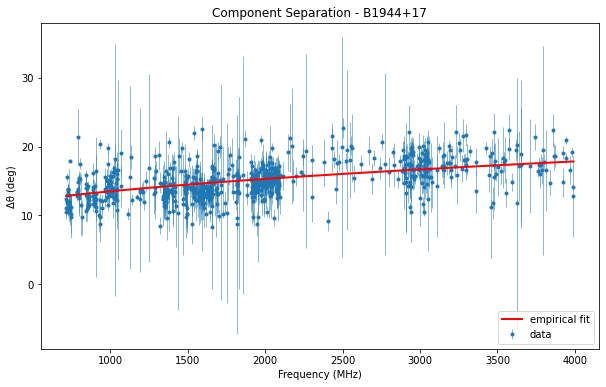

In [56]:
#Plot the thorsett fit
py.figure(figsize=(10, 6))
py.errorbar(frequency_forsep, comp_sep, yerr=sep_error, fmt='.', lw=0.5, label='data',zorder=1)
py.plot(frequency_forsep,separation_fit, color='red',lw=2,label='empirical fit',zorder=2)
py.title('Component Separation - B1944+17')
py.xlabel('Frequency (MHz)')
py.ylabel('\u0394\u03B8 (deg)')
py.legend(loc='lower right')


In [57]:
#chi, p = sp.stats.chisquare(comp_sep, separation_fit)
print(f'The equation of fit for this pulsar is: \t \u0394\u03B8 = {sep_params[0]:.3f} \u03BD^{sep_params[1]:.3f} + {sep_params[2]:.3f} \n')
print(f'The errors are {sep_fit_error[0]:.3f}, {sep_fit_error[1]:.3f}, {sep_fit_error[2]:.3f} ')
#print('The chi squared value for the fit is: ', chi)
print('Units for \u0394\u03B8 is degrees and \u03BD is MHz')
print('The chi squared reduced value is',chsq_err(comp_sep, separation_fit, sep_error)/(len(comp_sep)-2))

The equation of fit for this pulsar is: 	 Δθ = 0.137 ν^0.500 + 9.164 

The errors are 0.301, 0.232, 2.568 
Units for Δθ is degrees and ν is MHz
The chi squared reduced value is 3.8352783173377794


## Parkes and EPN

In [58]:
#Gain component separation values
ant_sep, ant_error = separation_singleprofile(ant_components)
gl_sep, gl_error = separation_singleprofile(gl_components)
j_sep, j_error = separation_singleprofile(j_components)
wc_sep, wc_error = separation_singleprofile(wc_components)
sgg_sep, sgg_error = separation_singleprofile(sgg_components)

epn_sep = [ant_sep, gl_sep, j_sep, wc_sep, sgg_sep]
epn_error = [ant_error, gl_error, j_error, wc_error, sgg_error]

epn_seps=[]
frequency_epn=[]
epn_errors=[]

#Put them into arrays for graphing
for k,epn in enumerate(epn_sep):
    for i in range(0,len(epn)):
        comp_sep.append(epn[i][1])
        frequency_forsep.append(epn[i][0])
        sep_error.append(epn_error[k][i])

        epn_seps.append(epn[i][1])
        frequency_epn.append(epn[i][0])
        epn_errors.append(epn_error[k][i])

In [59]:
epn_sep

[[component_separation(frequency=400, separation=13.121290455683464),
  component_separation(frequency=800, separation=14.65835504125883),
  component_separation(frequency=1330, separation=15.567699695482787),
  component_separation(frequency=1640, separation=16.31294112478261)],
 [component_separation(frequency=410, separation=11.10132391690243),
  component_separation(frequency=610, separation=12.823880712970833),
  component_separation(frequency=925, separation=13.771958731232957),
  component_separation(frequency=1408, separation=14.73817595847595)],
 [component_separation(frequency=673.9, separation=13.617310219134481)],
 [component_separation(frequency=1418, separation=11.431643163462525)],
 [component_separation(frequency=1420, separation=12.120002525867932),
  component_separation(frequency=4750, separation=20.304352220871735)]]

In [60]:
#Create a thorsett fit
expect=(703,0.4,16)
sep_params,sep_cov=curve_fit(thorsett,frequency_forsep,comp_sep, expect, maxfev=10000, sigma=sep_error, bounds=([0,-1,-np.inf],[np.inf,0.5,np.inf]))
sep_fit_error=np.sqrt(np.diag(sep_cov))

freq_fit = np.linspace(300, 4900, 460)
separation_fit=thorsett(freq_fit,*sep_params)

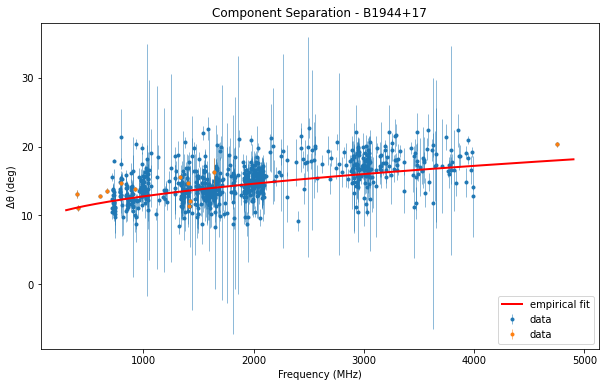

In [61]:
#Plot the thorsett fit
py.figure(figsize=(10, 6))
py.errorbar(frequency_forsep, comp_sep, yerr=sep_error, fmt='.', lw=0.5, label='data',zorder=1)
py.errorbar(frequency_epn, epn_seps, yerr=epn_errors, fmt='.', lw=0.5, label='data',zorder=2)
py.plot(freq_fit,separation_fit, color='red',lw=2,label='empirical fit',zorder=3)
py.title('Component Separation - B1944+17')
py.xlabel('Frequency (MHz)')
py.ylabel('\u0394\u03B8 (deg)')
py.legend(loc='lower right')

# Change in Intensity over Frequency for GMRT

## Fit Peaks (fit_components)

Text(0, 0.5, 'Intensity')

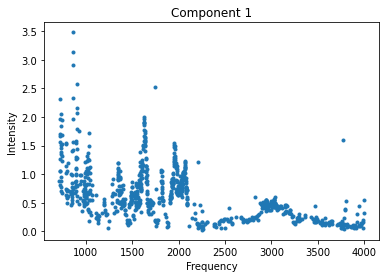

In [62]:
#Find intensity of components at each frequency and graph
intensity_comp1=[]
frequency_comp1=[]

for i in range(0,len(fit_components)):
  if fit_components[i][1][0] != 0:
    intensity_comp1.append(fit_components[i][1][1])
    frequency_comp1.append(fit_components[i][0])
    
py.plot(frequency_comp1,intensity_comp1, '.')
py.title('Component 1')
py.xlabel('Frequency')
py.ylabel('Intensity')

Text(0, 0.5, 'Intensity')

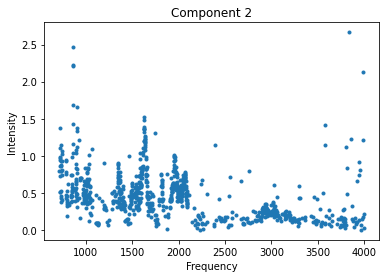

In [63]:
#Find intensity of components at each frequency and graph
intensity_comp2=[]
frequency_comp2=[]

for i in range(0,len(fit_components)):
  if fit_components[i][1][0] != 0:
    intensity_comp2.append(fit_components[i][2][1])
    frequency_comp2.append(fit_components[i][0])

py.plot(frequency_comp2,intensity_comp2, '.')
py.title('Component 2')
py.xlabel('Frequency')
py.ylabel('Intensity')

In [64]:
int_ratio=np.array(intensity_comp1)/np.array(intensity_comp2)

Text(0, 0.5, 'Intensity Ratio')

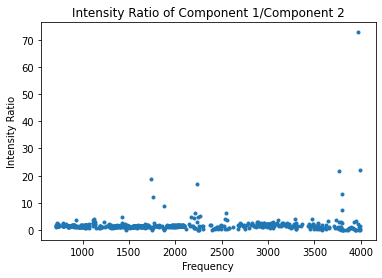

In [65]:
py.plot(frequency_comp2,int_ratio, '.')
py.title('Intensity Ratio of Component 1/Component 2')
py.xlabel('Frequency')
py.ylabel('Intensity Ratio')